<a href="https://colab.research.google.com/github/SupermarketAutomationAI/data_processing/blob/main/data_generation_with_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Data

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/My Drive/APS360 Project/Dataset Zip Files/V2_combinedDS' -d '/root/datasets'

In [ ]:
# Clean the data, remove "._" from file names
import os
from glob import glob
parent_dir = "/root/datasets/SupermarketAutomationAI_Dataset_V1"
classes = ['Multiple Bananas', 'Multiple Fuji Apples', 'Multiple Gala Apples', 'Multiple Golden Delicious Apples', 
           'Multiple Granny Smith Apples', 'Multiple Oranges', 'Multiple Red Delicious Apples', 'One Banana', 
           'One Fuji Apple', 'One Gala Apple', 'One Golden Delicious Apple', 'One Granny Smith Apple', 'One Orange', 
           'One Red Delicious Apple']

for cat in classes:
    path = parent_dir + '/' + cat
    invalid_files = glob(os.path.join(path,"._*"))
    for file_ in invalid_files:
        os.rename(file_, os.path.join(path,file_.split('/')[-1].replace("._","")))

## Split the data

In [4]:
# Import the necessary libraries
import json
import os
import math
import shutil

In [5]:
# create data directory and move all images into it
# parent_dir = "/root/datasets/SupermarketAutomationAI_Dataset_V1"
# parent_dir = "/root/datasets/V3_combined_all_DS"
parent_dir = "/root/datasets/V2_combinedDS"
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
data_dir = parent_dir + '/' + "data"
os.mkdir(data_dir, 755)
for category in category_list:
    cat_dir = parent_dir + '/' + category
    shutil.move(cat_dir, data_dir)

In [6]:
train_split = 0.6

dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
 path = parent_dir + '/'+ dsdirs
 os.mkdir( path,755 )

for category in category_list: 
    src_path = parent_dir + '/data/' + category
    train_dir = parent_dir + '/train/' + category + '/'
    val_dir = parent_dir + '/val/' + category + '/'
    test_dir = parent_dir + '/test/' + category + '/'
    
    os.mkdir(train_dir, 755 )
    os.mkdir(val_dir, 755)
    os.mkdir(test_dir, 755)

    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]

    #get training, testing and validation files count
    train_count = math.ceil(train_split*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count

    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count-1]
    valid_data_list = files[train_count:train_count+valid_count-1] 
    test_data_list = files[train_count+valid_count:]


    for train_data in train_data_list:
        train_path = src_path + '/' + train_data
        shutil.move(train_path,train_dir)

    for valid_data in valid_data_list:
        valid_path = src_path + '/' + valid_data
        shutil.move(valid_path,val_dir)

    for test_data in test_data_list:
        test_path = src_path + '/' + test_data
        shutil.move(test_path,test_dir)

    # Move any files that are left behind into the training directory
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    for img_left_behind in files:
        img_path = src_path + '/' + img_left_behind
        shutil.move(img_path, train_dir)

## Preprocess data into Dataloaders

In [8]:
# List different classes
'''
# V1 dataset
classes = ['Multiple Bananas', 'Multiple Fuji Apples', 'Multiple Gala Apples', 'Multiple Golden Delicious Apples', 
           'Multiple Granny Smith Apples', 'Multiple Oranges', 'Multiple Red Delicious Apples',
           'One Banana', 'One Fuji Apple', 'One Gala Apple', 'One Golden Delicious Apple',
           'One Granny Smith Apple', 'One Orange', 'One Red Delicious Apple']
'''
# V2 dataset
classes = ['Banana', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
           'Granny_Smith_Apple', 'Orange', 'Red_Delicious_Apple']

# # V3 dataset
# classes = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
#            'Granny_Smith_Apple', 'Guava', 'Kiwi', 'Mango', 'Orange', 
#            'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate',
#            'Red_Delicious_Apple', 'Tomatoes', 'muskmelon']


In [9]:
# Remove hidden files & directories that break data loader
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  !find $path -name '._*' -delete
  print("Deleted ._* files from {0}".format(path))

Deleted ._* files from /root/datasets/V2_combinedDS/train
Deleted ._* files from /root/datasets/V2_combinedDS/val
Deleted ._* files from /root/datasets/V2_combinedDS/test


In [10]:
# import needed libraries for this section
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data.sampler import SubsetRandomSampler

In [11]:
# define the locations of the training and validation data
# parent_dir = "/root/datasets/V3_combined_all_DS"
train_dir = os.path.join(parent_dir, 'train/')
val_dir = os.path.join(parent_dir, 'val/')
test_dir = os.path.join(parent_dir, 'test/')

# three possible transforms, will test each to see which gives better results
data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

# apply the transforms to the data
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_CC_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_CC_transform)

# print the amount of data in both training and validation sets
print("Amount of training data: ", len(train_data))
print("Amount of validation data: ", len(val_data))
print("Amount of test data: ", len(test_data))

Amount of training data:  6928
Amount of validation data:  2306
Amount of test data:  2294


In [12]:
def get_relevant_indices(dataset, classes, target_classes):
  '''
  Return the indices for datapoints in the dataset that belongs to the desired
  target classes
  '''
  if target_classes == classes:
    return list(range(len(dataset)))

  indices = []
  for i in range(len(dataset)):
    # Check if the label is in the target class
    label_index = dataset[i][1]
    label_class = classes[label_index]
    if label_class in target_classes:
      indices.append(i)
  return indices

## VAE to generate data

In [13]:
batch_size = 128
target_classes = ['Banana', 'Orange', 'Fuji_Apple']

train_sampler = SubsetRandomSampler(get_relevant_indices(train_data, classes, target_classes))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(get_relevant_indices(val_data, classes, target_classes))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, sampler=val_sampler)

test_sampler = SubsetRandomSampler(get_relevant_indices(test_data, classes, target_classes))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, sampler=test_sampler)

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [52]:
zdimCNN = 200

class vaeCNN(nn.Module):
    def __init__(self):
        super(vaeCNN, self).__init__()

        # encoder
        self.fc1 = nn.Conv2d(3, 5, 5, stride=2, padding=1)
        self.fc2 = nn.Conv2d(5, 10, 5, stride=2, padding=1)
        self.fc3 = nn.Conv2d(10, 3, 3)
        self.fc4m = nn.Linear(3 * 53 * 53, zdimCNN)
        self.fc4s = nn.Linear(3 * 53 * 53, zdimCNN)
        
        # decoder
        self.fc5 = nn.Linear(zdimCNN, 3 * 53 * 53)
        self.fc6 = nn.ConvTranspose2d(3, 10, 3)
        self.fc7 = nn.ConvTranspose2d(10, 5, 5, stride=2, padding=1 )
        self.fc8 = nn.ConvTranspose2d(5, 3, 5, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()
        
        self.Lrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()

    
    def encode(self, x):  # create tensor (feat_size, zdimCNN)
        # print(x.shape)
        x = self.Lrelu(self.fc1(x))
        # print(x.shape)
        x = self.Lrelu(self.fc2(x))
        # print(x.shape)
        x = self.Lrelu(self.fc3(x))
        # print(x.shape)
        return self.fc4m(x.view(-1, 3*53*53)), self.fc4s(x.view(-1, 3*53*53))

    # reparameterize
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):  # create tensor shape 224*224*3
        # print(z.shape)
        z = self.relu(self.fc5(z))
        # print(z.shape)
        z = self.relu(self.fc6(z.view(-1, 3, 53, 53)))
        # print(z.shape)
        z = self.relu(self.fc7(z))
        # print(z.shape)
        z = self.relu(self.fc8(z))
        # print(z.shape)
        return self.sigmoid(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [28]:
# loss function for VAE are unique and use Kullback-Leibler
# divergence measure to force distribution to match unit Gaussian
def loss_function(recon_x, x, mu, logvar):
    bce = F.binary_cross_entropy(recon_x, x)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= batch_size *3 * 224 * 224
    return bce + kld

In [18]:
def train(model, train_loader, num_epochs=5, batch_size=64, learning_rate=1e-3):
    model.train()
    torch.manual_seed(42)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    count = 0

    for epoch in range(num_epochs):
        # print(epoch)
        for data in train_loader:
            
            img, _ = data

            if use_cuda and torch.cuda.is_available():
               img = img.cuda()

            recon, mu, logvar = model(img)
            loss = loss_function(recon, img, mu, logvar)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if count % 20 == 0:
                # display images
                realim = img[0].cpu()
                plt.imshow(np.transpose(realim, (2, 1, 0)))

                reconim = recon[0].cpu()
                plt.imshow(np.transpose(reconim.detach().numpy(), (2, 1, 0)))
                                
            count += 1
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

iscuda
Epoch:1, Loss:0.6864
Epoch:2, Loss:0.6701
Epoch:3, Loss:0.6654
Epoch:4, Loss:0.6599
Epoch:5, Loss:0.6574
Epoch:6, Loss:0.6618
Epoch:7, Loss:0.6615
Epoch:8, Loss:0.6533
Epoch:9, Loss:0.6524
Epoch:10, Loss:0.6456
Epoch:11, Loss:0.6510
Epoch:12, Loss:0.6501
Epoch:13, Loss:0.6506
Epoch:14, Loss:0.6515
Epoch:15, Loss:0.6442
Epoch:16, Loss:0.6471
Epoch:17, Loss:0.6471
Epoch:18, Loss:0.6482
Epoch:19, Loss:0.6434
Epoch:20, Loss:0.6344
Epoch:21, Loss:0.6433
Epoch:22, Loss:0.6387
Epoch:23, Loss:0.6331
Epoch:24, Loss:0.6417
Epoch:25, Loss:0.6333
Epoch:26, Loss:0.6368
Epoch:27, Loss:0.6371
Epoch:28, Loss:0.6389
Epoch:29, Loss:0.6374
Epoch:30, Loss:0.6376
Epoch:31, Loss:0.6361
Epoch:32, Loss:0.6385
Epoch:33, Loss:0.6312
Epoch:34, Loss:0.6332
Epoch:35, Loss:0.6382
Epoch:36, Loss:0.6329
Epoch:37, Loss:0.6410
Epoch:38, Loss:0.6284
Epoch:39, Loss:0.6361
Epoch:40, Loss:0.6324


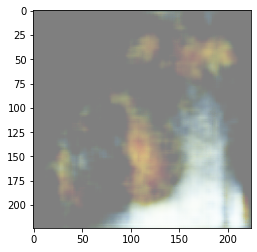

In [53]:
# model = Autoencoder()
model = vaeCNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
    print("iscuda")
    model = model.cuda()

train(model, train_loader=train_loader, num_epochs=40, batch_size=batch_size, learning_rate=1e-3)

In [54]:
# generate random samples in latent space
model.eval()
sample = torch.randn(batch_size, zdimCNN)
if use_cuda and torch.cuda.is_available():
    print("iscuda")
    sample = sample.cuda()
sample = model.decode(sample)

iscuda


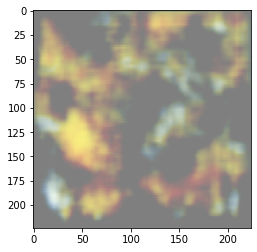

In [55]:
sample = sample.cpu()
imgs = np.transpose(sample.data.numpy(), (0, 3, 2, 1))
plt.imshow(imgs[4])

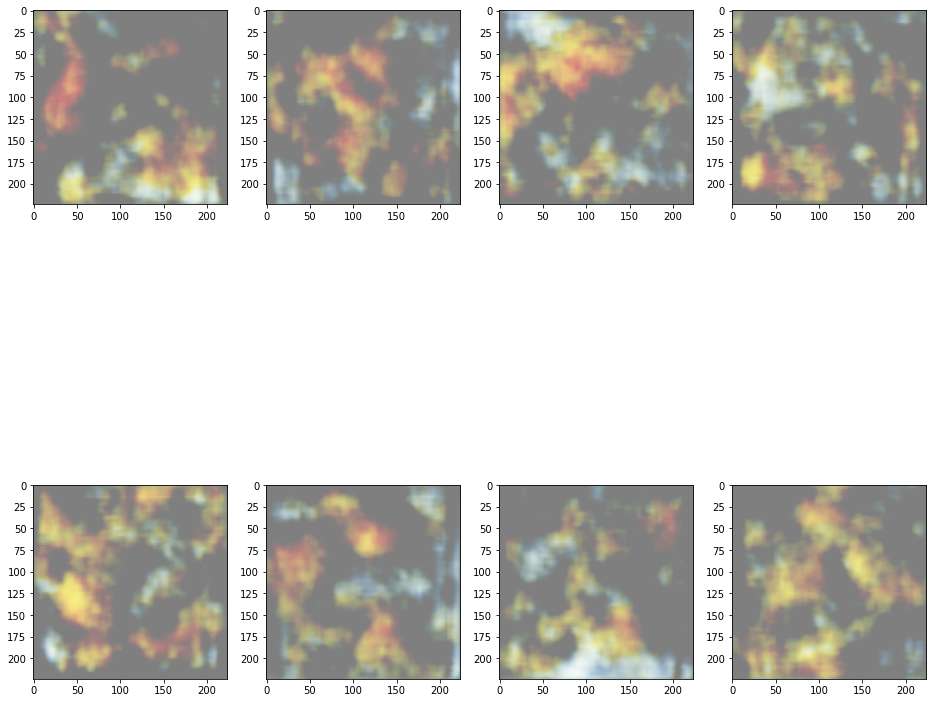

In [56]:
# display images
for k in range(1):
    plt.figure(figsize=(16, 16))

    for i, item in enumerate(imgs):
        if i >= 8:
            break
        plt.subplot(2, 4, i+1)
        plt.imshow(item)

## DCGAN model to generate data
referred: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [33]:
# Batch size during training
# batch_size = 64
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Size of z latent vector (i.e. size of generator input)
zdimGAN = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# device
device = "cuda:0"

In [34]:
# initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is zdim, going into a convolution
            nn.ConvTranspose2d(zdimGAN, ngf * 16, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 7, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 14 x 14
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 28 x 28
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 56 x 56
            nn.ConvTranspose2d( ngf * 2, ngf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 112 x 112
            nn.ConvTranspose2d( ngf, 3, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. 3 x 224 x 224
        )

    def forward(self, input):
        return self.main(input)


In [35]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is 3 x 224 x 224
            nn.Conv2d(3, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 112 x 112
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 56 x 56
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 28 x 28
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 14 x 14
            nn.Conv2d(ndf * 8, ndf * 16, 7, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
use_cuda = True

netG = Generator(ngpu)
netD = Discriminator(ngpu)
if use_cuda and torch.cuda.is_available():
    print("iscuda")
    netG = netG.cuda()
    netD = netD.cuda()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
netD.apply(weights_init)

In [37]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, zdimGAN, 1, 1)
if use_cuda and torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [38]:
def train_gan(d_model, g_model, dataloader, num_epochs=5, lr=0.0002):
    # Training Loop
    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            img, _ = data
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            
            b_size = img.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float)
            # Generate batch of latent vectors
            noise = torch.randn(b_size, zdimGAN, 1, 1)

            if use_cuda and torch.cuda.is_available():
                # print("iscuda")
                img = img.cuda()
                label = label.cuda()
                noise = noise.cuda()


            # Forward pass real batch through D
            output = netD(img).squeeze()
            # output = netD(img)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)

            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
           
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            # output = netD(fake.detach()).view(-1)
            output = netD(fake.detach()).squeeze()
            
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
    return img_list, G_losses, D_losses

In [39]:
img_list, G_losses, D_losses = train_gan(netD, netG, train_loader, num_epochs=10)

Starting Training Loop...
[0/10][0/32]	Loss_D: 2.0532	Loss_G: 28.0047	D(x): 0.5786	D(G(z)): 0.6100 / 0.0000
[1/10][0/32]	Loss_D: 0.0008	Loss_G: 63.3493	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[2/10][0/32]	Loss_D: 0.0000	Loss_G: 63.4265	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/10][0/32]	Loss_D: 0.0000	Loss_G: 63.2789	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/10][0/32]	Loss_D: 0.0000	Loss_G: 63.1029	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/10][0/32]	Loss_D: 0.0001	Loss_G: 63.2144	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[6/10][0/32]	Loss_D: 0.0000	Loss_G: 63.2480	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[7/10][0/32]	Loss_D: 0.0000	Loss_G: 62.9044	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[8/10][0/32]	Loss_D: 0.0000	Loss_G: 63.1328	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[9/10][0/32]	Loss_D: 0.0000	Loss_G: 63.0578	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


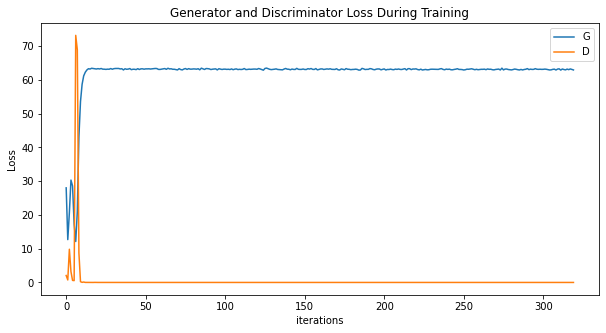

In [40]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

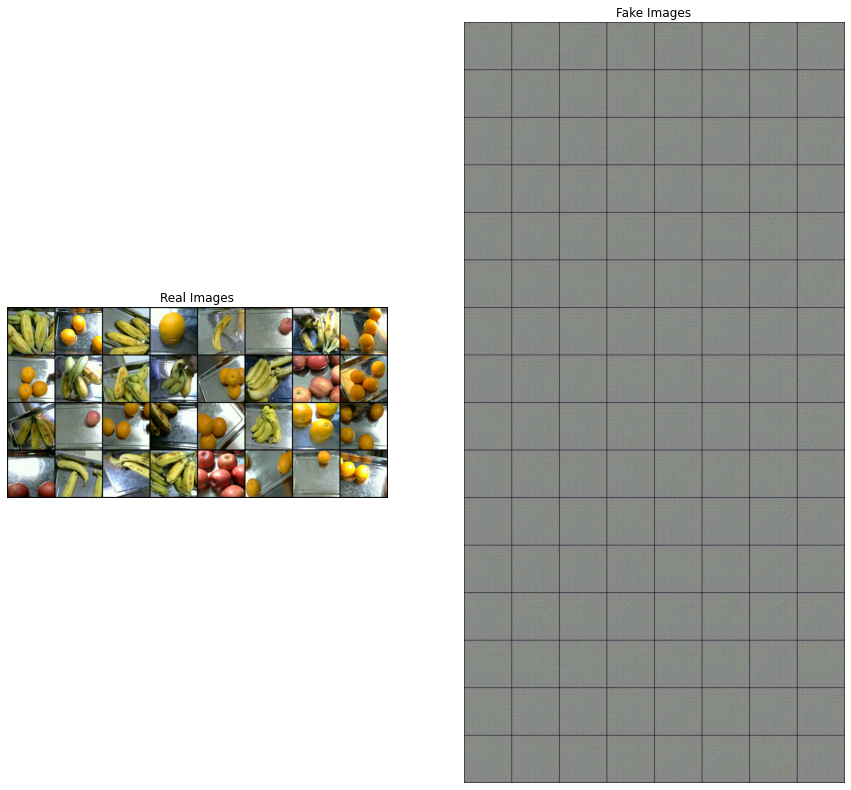

In [41]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()